## pre-pocessing

In [66]:
import pandas as pd
import json
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import random
import gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
from sklearn.svm import SVC
import torch
import torch.utils.data as Data
import torchvision

## Import dataset

In [67]:
path = "dataset/"

In [68]:
df = pd.read_csv(path+"USvideos.csv")
df = df.assign(country="US")
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')  
df.trending_date = df.trending_date.dt.date   
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df=df.assign(publish_date=df['publish_time'].dt.date)
df['publish_time'] = df['publish_time'].dt.time

###导入category名称###
df=df.assign(cat_name='a')
id_to_category = {}
file=path+'US_category_id.json'
with open(file, 'r') as f:
    data=json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']
print(id_to_category)
###实际上每个国家的category id-name 字典是一样的
df['category_id'] = df['category_id'].astype(str)
df.insert(4, 'category', df['category_id'].map(id_to_category))

## Clean Data

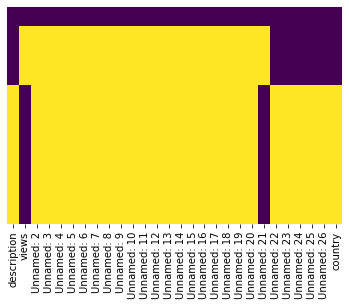

In [69]:
df_summary = df.describe(include="all")

# Use heatmap to check missing data
sb.heatmap(df_summary.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [70]:
# See counts of missing value
for c in df_summary.columns:
    print(c,np.sum(df_summary[c].isnull()))

description 7
views 3
Unnamed: 2 10
Unnamed: 3 10
Unnamed: 4 10
Unnamed: 5 10
Unnamed: 6 10
Unnamed: 7 10
Unnamed: 8 10
Unnamed: 9 10
Unnamed: 10 10
Unnamed: 11 10
Unnamed: 12 10
Unnamed: 13 10
Unnamed: 14 10
Unnamed: 15 10
Unnamed: 16 10
Unnamed: 17 10
Unnamed: 18 10
Unnamed: 19 10
Unnamed: 20 10
Unnamed: 21 3
Unnamed: 22 7
Unnamed: 23 7
Unnamed: 24 7
Unnamed: 25 7
Unnamed: 26 7
country 7


In [72]:

df.sample(5)
# Replace missing data
df_summary['description'].fillna("", inplace=True)
# df_summary['title'].fillna("", inplace=True)
# df_summary['category_id'].fillna(0, inplace=True)


# for k,v in df_summary.items():
#     print(type(df_summary[k]))
#     print("hhh")
#     df_summary[k].fillna(int(df_summary[k].mean()), inplace=True)

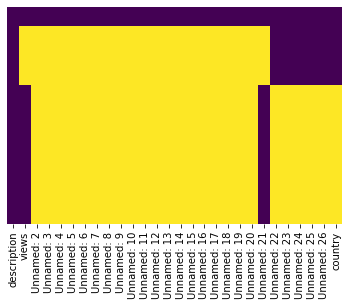

In [73]:
# Drop a column most value are missing
# df_summary.drop(['thumbnail_link'], axis=1, inplace=True)
sb.heatmap(df_summary.isnull(), yticklabels=False, cbar=False, cmap='viridis')

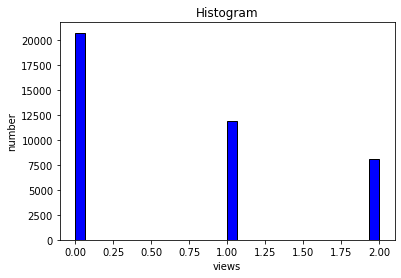

In [82]:
# normalize
# Import the libraries

# plt.plot(df['views'],df['view'])
# matplotlib histogram
plt.hist(df['views'], color = 'blue', edgecolor = 'black',
         bins = int(30))

# # seaborn histogram
# sb.distplot(df['view'], hist=True, kde=False, 
#              bins=int(180/5), color = 'blue',
#              hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram')
plt.xlabel('views')
plt.ylabel('number')

# np.sum(df['views']>2.35e6)
y_train = np.zeros_like(df['views'])
y_train[df['views']>7e5] = 1
y_train[df['views']>2.35e6] = 2
# y_train = df['views']
# y_train.shape
# np.median(df['views'])

In [75]:
# df['description']
# np.arange(1,df.size(),1)
# df['views']>2e8
df['description'][1435]#.idxmin(axis = 0)

"Luckily the priests were there.\\nIf you liked this clip check out the rest of Gordon's channels:\\n\\nhttp://www.youtube.com/gordonramsay\\nhttp://www.youtube.com/thefword\\nhttp://www.youtube.com/kitchennightmares\\n\\nMore Gordon Ramsay:\\nWebsite: http://www.gordonramsay.com\\nFacebook: http://www.facebook.com/GordonRamsay01\\nTwitter: http://www.twitter.com/GordonRamsay"

In [83]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
train_X, test_X = train_test_split(df, test_size=0.1, random_state=42)
train_y, test_y = train_test_split(y_train, test_size=0.1, random_state=42)
len(test_data)

4073

In [84]:
df['views'].shape

(40726,)

## Big of Words

In [78]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [79]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['description'].values.astype('U')) #3000*train_feature
test_data_features = count_vectorizer.transform(test_data['description'].values.astype('U')) #3000*train_feature

Wall time: 1min 41s


## Word Vectors

In [14]:
%%time 
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model = api.load("glove-twitter-25")  # download the model and return as object ready for use
# model.most_similar("cat")


Wall time: 36 s


In [15]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
#             print(wv.vocab[word].index)
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
#         logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(25,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float64)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [17]:
from itertools import islice
list(islice(model.vocab, 13000, 13020))
model.most_similar("cat")
model.syn0norm.shape

C:\Users\gx\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  after removing the cwd from sys.path.


(1193514, 25)

In [18]:

def w2v_tokenize_text(text):
    tokens = []
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

# def custom_tokenize(text):
#     if not text:
#         print('The text to be tokenized is a None type. Defaulting to blank string.')
#         text = ''
#     return word_tokenize(text)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [19]:
# print(type(test_data['description']))
# print(type(test_data.at['description',4729]))
# test_data['description'].dropna(inplace=True)
# train_data['description'].dropna(inplace=True)
# print(train_data['description'].iloc[4729])
# test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['description']), axis=1).values
# train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['description']), axis=1).values
# test_tokenized = df.description.apply(nltk.word_tokenize)

# train_data.dropna(subset=['description'])
# test_data.dropna(subset=['description'])
test_tokenized = test_data["description"].fillna("").map(w2v_tokenize_text)
train_tokenized = train_data["description"].fillna("").map(w2v_tokenize_text)


# df.sample(5)
# na.omit(dat)

The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None

The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None

The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None type. Defaulting to blank string.
The text to be tokenized is a None

In [112]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

C:\Users\gx\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


Wall time: 11.7 s


## LSTM

In [41]:

def word_append(wv, words):
    all_words, mean = set(), []
#     count = 0
    for word in words:
#         count+=1
#         if count>69:
#             break
        if len(mean)>99:
            break
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
#             print(wv.vocab[word].index)
            mean.append(wv.syn0norm[wv.vocab[word].index])
#             print(wv.syn0norm[wv.vocab[word].index].shape)
            all_words.add(wv.vocab[word].index)
#     print("=============================")
#     print(len(mean))
#     if count<70:
    lengt = len(mean)
    if lengt<100:
        for i in range(100-lengt):
            x = np.zeros((25,))
            mean.append(x)
#     print(len(mean))
#     print(count)
#     print(mean.shape)
    if not mean:
#         logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        print("not mean")
        return np.zeros(25,)

    mean = gensim.matutils.unitvec(np.array(mean)).astype(np.float32)
#     mean = np.array(mean)
#     print(mean.shape)
#     print(mean)
#     cccount+=1
#     print(cccount)
    
    return mean

def  word_list(wv, text_list):
    ret = []
#     i = 0
    for review in text_list:
#         i+=1
#         print(i,":")
        x = word_append(wv, review)
#         print(x.size())
        ret.append(x)
    return ret
#     return np.vstack([word_append(wv, review) for review in text_list ])

X_train_word = word_list(model,train_tokenized)
X_test_word = word_list(model,test_tokenized)

# X_train_word = word_list(model,['SHANTELL', "'S", 'CHANNEL', 'https'])

# print(train_tokenized[8])

C:\Users\gx\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


In [45]:
ave = 0
count=0
for i in X_train_word:
    ave += i.shape[0]
    count+=1
for i in X_test_word:
    ave += i.shape[0]
    count+=1
print(count)
print(ave/count)

print(np.array(X_train_word).shape)
print(np.array(X_test_word).shape)

X_train_words = np.array(X_train_word).reshape(-1,100,25)
X_test_words = np.array(X_test_word).reshape(-1,100,25)
print(X_test_words.shape)
features = np.concatenate((X_train_words,X_test_words),axis=0)
print(features.shape)



40949
100.0
(36854, 100, 25)
(4095, 100, 25)
(4095, 100, 25)
(40949, 100, 25)


In [46]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
encoded_labels = np.array(y_train)


length = len(features)
split = int(split_frac*length)

train_x,valid_x = features[:split],features[split:]
train_y,valid_y = encoded_labels[:split],encoded_labels[split:]

test_x,test_y = valid_x[len(valid_x)//2:],valid_y[len(valid_y)//2:]
valid_x,valid_y = valid_x[:len(valid_x)//2],valid_y[:len(valid_y)//2]
## print out the shapes of your resultant feature data
print('Train set : ',train_x.shape,train_y.shape)
print('Validation set : ',valid_x.shape,valid_y.shape)
print('Test set : ',test_x.shape,test_y.shape)



Train set :  (32759, 100, 25) (32759,)
Validation set :  (4095, 100, 25) (4095,)
Test set :  (4095, 100, 25) (4095,)


In [47]:

import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [48]:

# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 100, 25])
Sample input: 
 tensor([[[ 4.0865e-03,  2.8314e-04,  1.6661e-03,  ...,  3.1024e-03,
           3.6803e-03, -3.8615e-03],
         [-1.0819e-02,  8.0137e-03,  9.8439e-03,  ...,  1.0166e-02,
           7.7864e-03, -1.0328e-02],
         [ 8.5514e-03,  1.4799e-02, -2.9018e-02,  ...,  6.8478e-03,
          -4.0938e-03, -1.1484e-02],
         ...,
         [ 1.9571e-02, -1.5400e-02, -1.5154e-02,  ..., -1.8230e-03,
           1.0738e-02,  2.7965e-03],
         [ 1.9571e-02, -1.5400e-02, -1.5154e-02,  ..., -1.8230e-03,
           1.0738e-02,  2.7965e-03],
         [ 1.9571e-02, -1.5400e-02, -1.5154e-02,  ..., -1.8230e-03,
           1.0738e-02,  2.7965e-03]],

        [[-1.3251e-02,  1.3172e-02,  6.0367e-03,  ..., -5.9420e-03,
           1.0465e-02, -2.0027e-02],
         [ 5.0139e-03,  5.4120e-03, -1.7084e-03,  ...,  9.8442e-03,
           3.8223e-03, -1.3325e-02],
         [-9.9126e-03,  7.7583e-03, -2.0886e-03,  ..., -6.3381e-04,
           1.7

In [49]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [50]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.7):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
#         self.embed = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=drop_prob,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_size)
        self.sigmoid = nn.Sigmoid()
        self.drp = nn.Dropout(p=0.7)

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.shape[0]
        
#         x = self.embed(x)
       
        x,hidden = self.lstm(x,hidden)
        
        x = x.reshape(-1,self.hidden_dim)
        
        x = self.drp(x)
        
        x = self.fc(x)
        
        sig_out = self.sigmoid(x)
        
        # return last sigmoid output and hidden state
        sig_out = sig_out.reshape(batch_size,-1)
        sig_out = sig_out[:,-1]
        
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        
        return hidden

In [55]:
# Instantiate the model w/ hyperparams
vocab_size = 1193514+1#???
output_size = 1
embedding_dim = 25
hidden_dim = 100
n_layers = 2

net = None
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (lstm): LSTM(25, 100, num_layers=2, batch_first=True, dropout=0.7)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (drp): Dropout(p=0.7, inplace=False)
)


In [56]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [58]:
# training params
validLoss,trainLoss = [],[]
epochs = 10 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping
minValidLoss = np.inf #use for saving model whenever valid loss becomes less than min valid loss

# move model to GPU, if available
device = 'cuda' if(torch.cuda.is_available()) else 'cpu'
net.to(device)
print("Running on",device)

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    print("e:",e)
    h = net.init_hidden(batch_size)
    print(h[0].shape)
    # batch loop
    print()
    for batch,(inputs, labels) in enumerate(train_loader,1):
        print(f'\rBatch : {batch}/{len(train_loader)}',end='')
        counter += 1
        
        if(train_on_gpu):
            inputs, labels = inputs.cuda().long(), labels.cuda().long()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        

        # zero accumulated gradients
        net.zero_grad()
        
#         htemp = tuple([each.data for each in h])
#         print(inputs[2].shape)
#         print("======================")
#         print(h[1].shape)
        # get the output from the model
        output, h = net(inputs, h)
#         print(h[1].shape)
        

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
#         print("ok")

        # loss stats
    else:
        # Get validation loss
        print("hahhahhahahahha")
        print()
        val_h = net.init_hidden(batch_size)
        val_losses = []
        net.eval()
        for inputs, labels in valid_loader:

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])

            if(train_on_gpu):
                inputs, labels = inputs.cuda().long(), labels.cuda().long()

            output, val_h = net(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

        net.train()
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.6f}...".format(loss.item()),
              "Val Loss: {:.6f}".format(np.mean(val_losses)))
        
        if(np.mean(val_losses)<minValidLoss):
          print('\t\t...Saving Model...')
          torch.save(net.state_dict(),'LSTM_Model.pt')
          minValidLoss = np.mean(val_losses)
          
        trainLoss.append(loss.item())
        validLoss.append(np.mean(val_losses))

Running on cpu
e: 0
torch.Size([2, 50, 100])

Batch : 655/655hahhahhahahahha

Epoch: 1/10... Step: 655... Loss: 0.716355... Val Loss: 0.545677
		...Saving Model...
e: 1
torch.Size([2, 50, 100])

Batch : 655/655hahhahhahahahha

Epoch: 2/10... Step: 1310... Loss: 0.687574... Val Loss: 0.554471
e: 2
torch.Size([2, 50, 100])

Batch : 655/655hahhahhahahahha

Epoch: 3/10... Step: 1965... Loss: 0.672308... Val Loss: 0.538521
		...Saving Model...
e: 3
torch.Size([2, 50, 100])

Batch : 655/655hahhahhahahahha

Epoch: 4/10... Step: 2620... Loss: 0.672880... Val Loss: 0.535200
		...Saving Model...
e: 4
torch.Size([2, 50, 100])

Batch : 655/655hahhahhahahahha

Epoch: 5/10... Step: 3275... Loss: 0.630923... Val Loss: 0.543875
e: 5
torch.Size([2, 50, 100])

Batch : 655/655hahhahhahahahha

Epoch: 6/10... Step: 3930... Loss: 0.643506... Val Loss: 0.538534
e: 6
torch.Size([2, 50, 100])

Batch : 655/655hahhahhahahahha

Epoch: 7/10... Step: 4585... Loss: 0.691135... Val Loss: 0.531363
		...Saving Model...

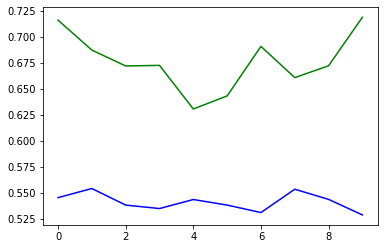

In [61]:
import matplotlib.pyplot as plt
plt.plot(trainLoss,color='g')
plt.plot(validLoss,color='b')
plt.show()

In [62]:
#Loading saved model
net.load_state_dict(torch.load('LSTM_Model.pt'))

if(train_on_gpu):
  net.to('cuda')
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda().long(), labels.cuda().long()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.474
Test accuracy: 0.392


In [63]:

#Loading saved model
net.load_state_dict(torch.load('LSTM_Model.pt'))

if(train_on_gpu):
  net.to('cuda')
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda().long(), labels.cuda().long()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.474
Test accuracy: 0.390
